#### Libraries

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import svm, datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from datetime import date, datetime, timedelta

#### Get The Testing Data Set Up

In [2]:
data = pd.read_csv('Resources/US_Data.csv')
data.head()

,Unnamed: 0,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,0,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,NaN,3470.0,1.0,75.988020,21583.0,437.0,2.610160,84000001.0,USA,460.300152,12.264945
1,1,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,2.0,45.504049,8038.0,31.0,2.941176,84000002.0,USA,1344.711576,11.397059
2,2,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427.0,4.0,48.662422,42109.0,NaN,3.246753,84000004.0,USA,578.522286,NaN
3,3,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,5.0,49.439423,19722.0,130.0,2.109375,84000005.0,USA,761.753354,10.156250
4,4,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,NaN,22155.0,6.0,58.137726,190328.0,5234.0,2.812020,84000006.0,USA,485.423869,22.961176


In [3]:
usa = data.groupby('Last_Update').sum()
usa = usa.drop(columns=['Lat', 'Long_', 'Unnamed: 0'])

for i in range(len(usa.index.values)):
    usa.index.values[i] = re.split(' +', usa.index.values[i])[0]

usa = usa.groupby('Last_Update').sum()
usa.head()

,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,Testing_Rate,Hospitalization_Rate
Last_Update,,,,,,,,,,,,
2020-04-12,555262,22018,34108.0,533244.0,3571.0,7349.862704,2805539.0,92248.0,179.129862,4.452192e+09,52305.870218,698.013149
2020-04-13,559600,23029,35442.0,536571.0,190637.0,7645.721482,2738796.0,89969.0,180.542529,4.368193e+09,54681.645813,713.066489
2020-04-14,628689,26330,37645.0,704359.0,190661.0,8723.524539,3277824.0,103850.0,192.053836,4.536193e+09,59146.540441,754.385940
2020-04-15,636350,28325,39405.0,608025.0,190649.0,8520.747540,3242752.0,103839.0,196.366401,4.452193e+09,61138.422190,743.813574
2020-04-16,667801,32916,42032.0,634885.0,190649.0,8963.545726,3401061.0,108942.0,202.639694,4.452193e+09,63666.828626,717.989665


In [4]:
X = np.array([[0]])
y = usa[["Confirmed", "Deaths"]]

# Might as well convert to 'days from first record date' to avoid datatype
# issues
for i in range(len(usa.index.values) - 1):
    X = np.concatenate((X, np.array([[i + 1]])))
print(X.shape, y.shape)

(129, 1) (129, 2)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print(f"Scalers: {scaler_x}, {scaler_y}")

Scalers: StandardScaler(), StandardScaler()


### Aggregate Analysis

In [6]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
print(model.score(X_test_scaled, y_test_scaled))

0.954628679188835


In [7]:
predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.045547170483415694, R2: 0.954628679188835


### Displaying Aggregate items

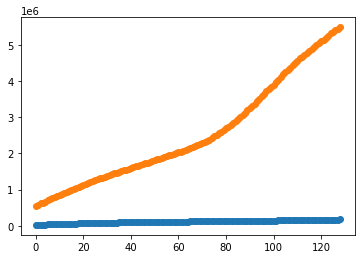

In [8]:
scatter_day = range(usa.count().min())
scatter_deaths = []
scatter_cases = []

for i in scatter_day:
    scatter_deaths.append(usa['Deaths'][i])
    scatter_cases.append(usa['Confirmed'][i])

plt.scatter(scatter_day, scatter_deaths)
plt.scatter(scatter_day, scatter_cases)

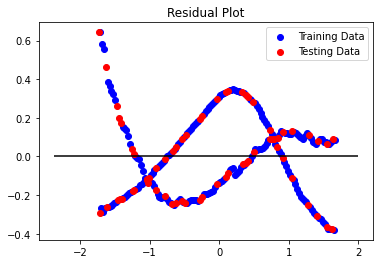

In [9]:
plt.scatter((model.predict(X_train_scaled)), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="red", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

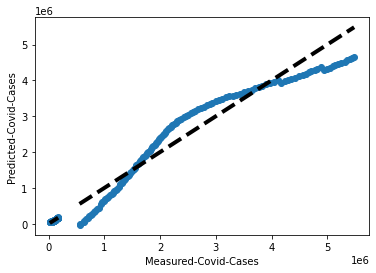

In [10]:
predicted = cross_val_predict(model, X, y, cv=10)
fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured-Covid-Cases')
ax.set_ylabel('Predicted-Covid-Cases')
plt.show()

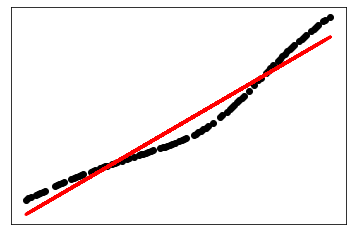

In [11]:
X = np.array([[0]])
y = usa[["Confirmed"]]

for i in range(len(usa.index.values) - 1):
    X = np.concatenate((X, np.array([[i + 1]])))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

linreg = linear_model.LinearRegression()

try:
    linreg.fit(X_train, y_train)
except ValueError:
    linreg.fit(X_train, y_train)

y_predict = linreg.predict(X_train)

plt.scatter(X_train, y_train, color='black')
plt.plot(X_train, y_predict, color='red', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

### Partial Predictability

In [12]:
X_months = {}

for date_holder in usa.index.copy().values.reshape(-1, 1):
    date = re.split('-', date_holder[0])

    try:
        X_months[date[1]] = X_months[date[1]].append(usa.loc[usa.index.values == date_holder[0]])
    except KeyError:
        X_months[date[1]] = usa.loc[usa.index.values == date_holder[0]]

print(X_months.keys())

dict_keys(['04', '05', '06', '07', '08'])


In [13]:
def CreateTrainingFields(test_x, test_y, rs):
    x_train, x_test, Y_train, Y_test = train_test_split(
        test_x, test_y, random_state=rs
    )

    scaler_x = StandardScaler().fit(x_train)
    scaler_y = StandardScaler().fit(Y_train)

    x_train_scaled = scaler_x.transform(x_train)
    x_test_scaled = scaler_days.transform(x_test)

    Y_train_scaled = scaler_y.transform(Y_train)
    Y_test_scaled = scaler_y.transform(Y_test)

    return(x_train, x_test, Y_train, Y_test, scaler_x, scaler_y, x_train_scaled, Y_train_scaled, Y_test_scaled)

In [26]:
def PredictValues(keyname, start, end, predictstart, predictend, df):
    # First set up the test range
    firstdate = datetime.fromisoformat(df.index.values.min())
    lastdate = datetime.fromisoformat(df.index.values.max())

    if (datetime.fromisoformat(start) < firstdate):
        print(f'Warning:  Start date {start} is before the first date in the data ({firstdate})')
        print('Defaulting to first date in the data')
        days_data = np.array([[0]])
    else:
        days_data = np.array([[(datetime.fromisoformat(start) - firstdate).days]])

    if (lastdate < datetime.fromisoformat(end)):
        print(f'Warning:  End date {end} is after the last date in the data ({lastdate})')
        print('Defaulting to up to the last date in the data')
        for i in range(days_data[0][0], df.count().max()):
            if (re.split('T', (firstdate + timedelta(days=i)).isoformat())[0] in df.index):
                days_data = np.concatenate((days_data, np.array([[i + 1]])))
    else:
        for i in range(days_data[0][0], (datetime.fromisoformat(end) - firstdate).days):
            if (re.split('T', (firstdate + timedelta(days=i)).isoformat())[0] in df.index):
                days_data = np.concatenate((days_data, np.array([[i + 1]])))
    
    # Then the range we're predicting
    days_pred = np.array([[(datetime.fromisoformat(predictstart) - firstdate).days]])

    for i in range(days_pred[0][0], (datetime.fromisoformat(predictend) - firstdate).days):
        if (re.split('T', (firstdate + timedelta(days=i)).isoformat())[0] in df.index):
            days_pred = np.concatenate((days_pred, np.array([[i + 1]])))
    
    # Now for the two sets of data
    trait = df[keyname][start:end].values.reshape(-1, 1)
    trait_pred = df[keyname][predictstart:predictend].values.reshape(-1, 1)
    
    # Then the linear predicting data module
    loc_linreg = linear_model.LinearRegression()
    
    try:
        loc_linreg.fit(days_data, trait)
    except ValueError:
        loc_linreg.fit(days_data, trait)

    linedata_reg = linreg.predict(days_data)

    # Plot the chart of the predicted line given our training data
    print(f'The linear regression for the dates {start} through {end}')
    plt.scatter(days_data, trait, color='black')
    plt.plot(days_data, linedata_reg, color='red', linewidth=3)
    plt.show()

    # Return useful stats
    print(f"X-Coefficient:\t{linreg.coef_[0][0]}")
    print(f"Y-Intercept:\t{linreg.intercept_[0]}")
    print(f"R^2:\t\t{linreg.score(days_data, trait)}\n")

    # Now create the predicted output
    linedata_pred = np.array([[float(days_pred[0][0]) * linreg.coef_[0][0] + linreg.intercept_[0]]])

    for i in range(days_pred[0][0], days_pred[-1][0]):
        if (re.split('T', (firstdate + timedelta(days=i)).isoformat())[0] in df.index):
            thing_to_add = np.array([[(float(i + 1) * linreg.coef_[0][0]) + linreg.intercept_[0]]])        
            linedata_pred = np.concatenate((linedata_pred, thing_to_add))

    # Plot the predicted output
    print(f'How it fits in the time interval {predictstart} through {predictend}')
    plt.scatter(days_pred, trait_pred, color='black')
    plt.plot(days_pred, linedata_pred, color='red', linewidth=3)
    plt.show()

    # Return the predicted R^2 value
    pred_sum = 0
    pred_count = 0
    pred_mean = 0
    sum_squares = 0
    explained_sum_squares = 0
    resid_sum_squares = 0
    det_coeff = 1

    tot_holder = []
    resid_holder = []
    
    for field in linedata_pred:
        pred_count += 1
        pred_sum += field[0]
        tot_holder.append(field[0])
    
    pred_mean = pred_sum / pred_count
    
    for field in linedata_pred:
        sum_squares += (field[0] - pred_mean) ** 2
    
    for field in trait_pred:
        explained_sum_squares += (field[0] - pred_mean) ** 2
        resid_holder.append(field[0])

    for i in range(len(tot_holder)):
        resid_sum_squares += (resid_holder[i] - tot_holder[i]) ** 2
    
    det_coeff = 1 - (resid_sum_squares / sum_squares)
    
    print(f'Residual Sum of Squares:\t{resid_sum_squares}')
    print(f'R^2:\t\t\t\t{det_coeff}')

The linear regression for the dates 2020-05-01 through 2020-05-30


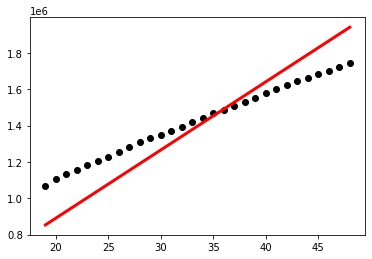

X-Coefficient:	37490.252605358
Y-Intercept:	141140.60829341505
R^2:		0.5772318959497511

How it fits in the time interval 2020-07-01 through 2020-07-31


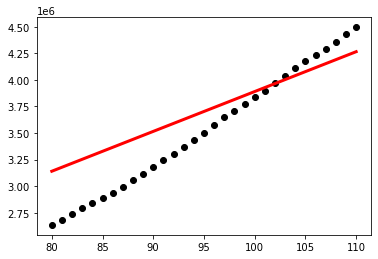

Residual Sum of Squares:	2642719218040.5474
R^2:				0.24183696038295188


In [27]:
PredictValues(
    'Confirmed',
    '2020-05-01',
    '2020-05-30',
    '2020-07-01',
    '2020-07-31',
    usa
)

The linear regression for the dates 2020-05-01 through 2020-05-30


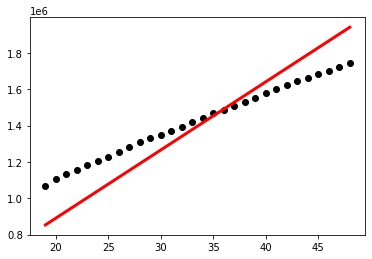

X-Coefficient:	37490.252605358
Y-Intercept:	141140.60829341505
R^2:		0.5772318959497511

How it fits in the time interval 2020-06-01 through 2020-06-30


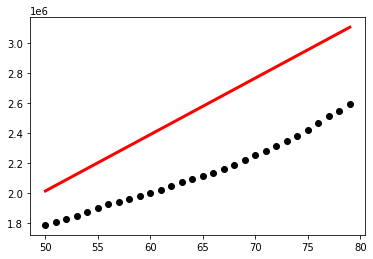

Residual Sum of Squares:	5695878996887.325
R^2:				-0.8031187141993443


In [29]:
PredictValues(
    'Confirmed',
    '2020-05-01',
    '2020-05-30',
    '2020-06-01',
    '2020-06-30',
    usa
)

In [17]:
usa['Confirmed']['2020-04-26':'2020-04-27'].values

array([938154, 965783], dtype=int64)

In [18]:
usa.index[0]

'2020-04-12'